# CP1 - Using Least Squares to De-blur images

In [2]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from functions import *

In [33]:
# importing image, changing to grey scale
image = cv.imread('fozzybear.jpg')

# changing the image to all grey to mitigate working with colors
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
print(gray_image.shape)

(450, 450)


We can see that the matrix representation for the grey version of the image is a "tall" matrix (m isn't much bigger than n) so using least squares on the matrix is justified.

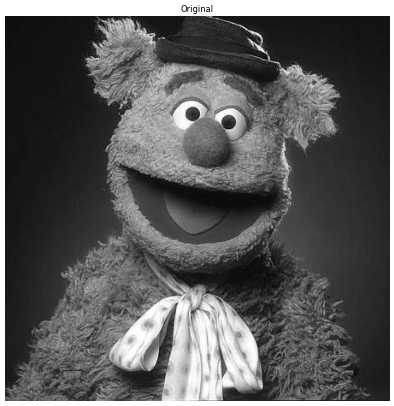

In [34]:
# Showing the original picture
fig = plt.figure(dpi = 50, figsize = (15,10))
plt.imshow(gray_image, cmap = 'gray')
plt.axis("off")
plt.title("Original")
plt.show()

In [9]:
# Creating the gray blurred guassian noise image
gaussian_noise = np.zeros_like(gray_image)
cv.randn(gaussian_noise, 128, 20) # mean of 128, sd of 20
gaussian_noise = (gaussian_noise * 0.5).astype(np.uint8)
blurred_rep = cv.blur(gaussian_noise, (15,15))

In [ ]:
## plotting blurred guassian noise
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# Plotting the Gaussian noise
axs[0].imshow(gaussian_noise, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Gaussian Noise')

# plotting blurred gaussian noise
axs[1].imshow(blurred_rep, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Blurred Gaussian Noise')

plt.show()

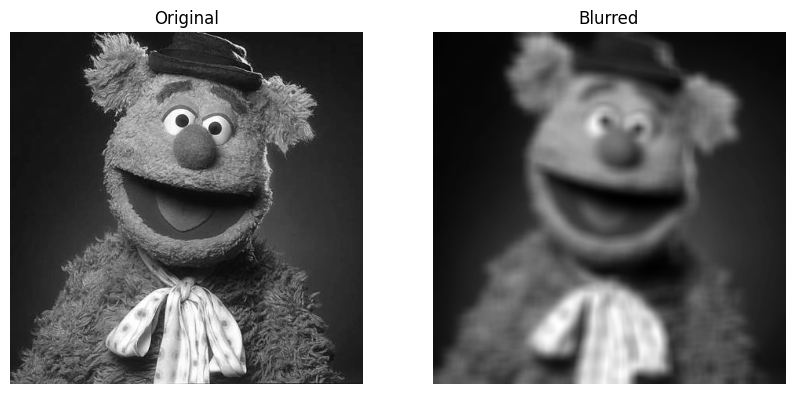

In [30]:
# blurring the (gray) image
blurred_image = cv.blur(gray_image, (15,15))

# showing comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 12))

# Plotting the original gray vs blurred gray image
axs[0].imshow(gray_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original')

axs[1].imshow(blurred_image, cmap='gray')
axs[1].axis("off")
axs[1].set_title("Blurred")
plt.show()

For deblurring the image, we will use different methods of least squares using the Normal Equation and QR factorization through the traditional method and using the Householder reflector to try to de-blur the image. Since the output we're trying to find the LSS for is a matrix, we can combine the LSS for each column of the real gray picture and combine them to get the real solution. The solution X, an array for this case, represents how to transform the blurred image so we will perform matrix multiplication between the blurred image and X.
The process of blurrring the photo isn't just a shifting of numbers that could perfectly reconstructed. The averaging of pixels in `cv.blur` necessitates uinsg least squares to reconstrcut the matrix representation closest to that of the original photo.  

In [23]:
def plottingFunction():
    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(1, 3, figsize=(10, 12))  # 1 row, 3 columns

    # Plotting the original image
    axs[0].imshow(blurred_image,cmap='gray')
    axs[0].axis("off")
    axs[0].set_title("Blurred")

    axs[1].imshow(reworked_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Transformed')

    axs[2].imshow(gray_image, cmap ='gray')
    axs[2].axis("off")
    axs[2].set_title("Original")
    plt.show()
    return None

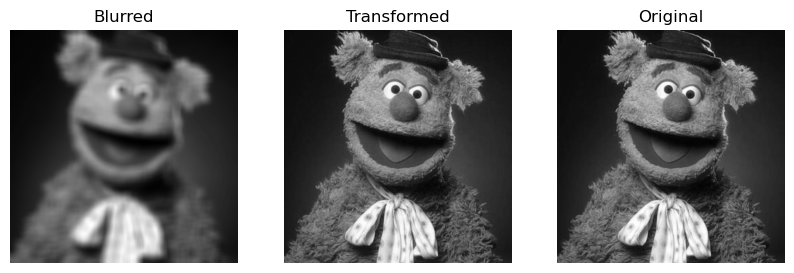

In [5]:
# sanity check using np.linalg.lstsq on entire matrix
x, _, _, _ = np.linalg.lstsq(blurred_image, gray_image, rcond = None)
reworked_image = blurred_image @ x

# plotting results 
plottingFunction()

The documentation for `np.linalg.lstsq` shows that if the second input, usually a vector that represents b in the overdetermined system, is an array (aka a matrix), then the process is performed on each column of the array and stitched together. To mimic this, we'll iterate through the columns of the matrix for the original matrix, using the various methods for each least sqaures solution. Since the matrices for the original and blurred images are both m x n, the matrix we're solving for is n x n.

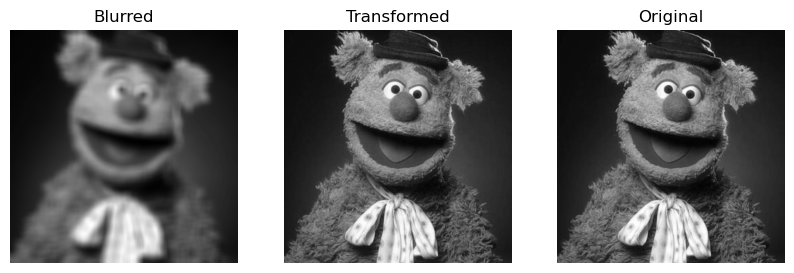

In [18]:
# second sanity check using np.linalg.lstsq iterating through each column vector
# get dimensions and create array for x 
(m, n) = blurred_image.shape
x = np.zeros((n,n))

# second sanity check: using np.linalg.lstsq on each column and stitching columns together in x
for i in range(n):
    x[:, i], _, _, _ = np.linalg.lstsq(blurred_image, gray_image[:, i], rcond = None)

reworked_image = blurred_image @ x

# showing result
plottingFunction()

In [24]:
# least sqaures using Normal equation on each column
(m, n) = blurred_image.shape
x = np.zeros((n,n))

for j in range(n):
    x[:, j] = Normal_Eq(blurred_image, gray_image[:, j])

reworked_image = blurred_image @ x

# showing results
plottingFunction()

KeyboardInterrupt: 

The results from using the Normal equation to transform the image suggest that the conditioning of the problem makes the normal equation an unsuitable method for this process.

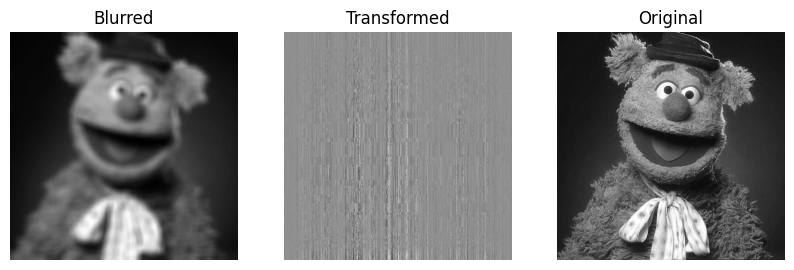

In [31]:
# least sqaures using reduced QR factorization on each column
(m, n) = blurred_image.shape
x = np.zeros((n,n))

Q, R = reduced_QR(blurred_image)

#x[:, j] = reduced_QR(blurred_image, gray_image[:, j])
x= np.linalg.solve(R, Q.T @ gray_image)

reworked_image = blurred_image @ x

# showing results
plottingFunction()

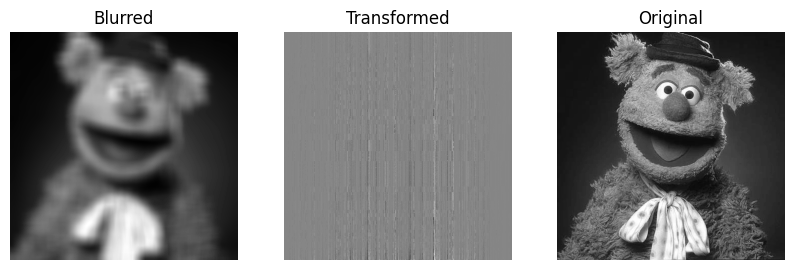

In [18]:
# least sqaures using full QR factorization on each column
(m, n) = blurred_image.shape
x = np.zeros((n,n))

Q, R = QR(blurred_image)
R = R[:n,:n]

for j in range(n):
    d = (Q.T @ gray_image[:, j])[:n]
    x[:, j] = np.linalg.solve(R, d)

reworked_image = blurred_image @ x

# showing results
plottingFunction()

For both reduced and full QR factorization, we used `np.linalg.qr` to speed up the computation. We included the regular code, but the nature of the nested loops during the deblurring process significantly increases the computation time. Without using the package, full QR factorization took about 20 minutes compared to 30 seconds using the package. For reduced QR factorization, it was 17 minutes compared to 26 seconds. Results will vary depending on hardware and software, but the difference in using the package is vast.

In [26]:
# least sqaures using the Householder reflector
(m, n) = blurred_image.shape
x = np.zeros((n,n))

Q, R = HH_QR(blurred_image)

x = Householder(Q, R, gray_image)

reworked_image = blurred_image @ x

# showing results
plottingFunction()

KeyboardInterrupt: 

Performing QR factorization using the Householder reflector took a long time (about 3 hours) because of the nested loop created by using the QR function every time in the loop. Using the more efficient householder QR code saved about 20 minutes from the computation. However, performing the QR factorization once via the Householder reflector and solving for the least squares solution sped up the computation time to about 20 seconds.